In [20]:
# !git clone https://github.com/facebookresearch/segment-anything.git

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ezjob65s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ezjob65s
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=13d0b09d611fca72aedac69728d6585c20b4da415c0d0c685e426a6fd0111bd9
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nz2m3b5/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-03-24 17:59:41--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
image = cv2.imread('/content/Single-crystalline_crystal.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

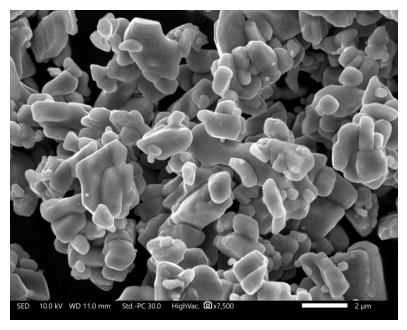

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
masks = mask_generator.generate(image)

In [10]:
print(len(masks))
print(masks[0].keys())

333
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


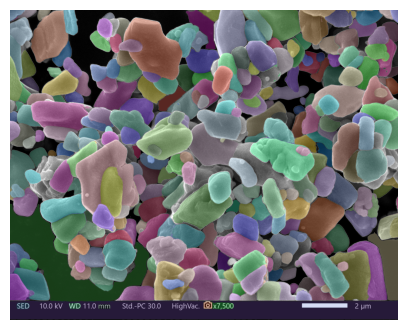

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

429

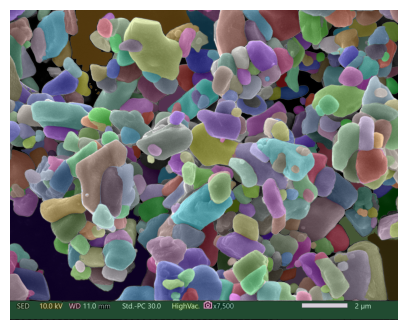

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

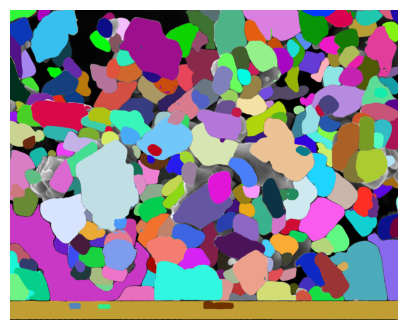

Saved combined masked image as 'masked_images/combined_masked_image.png'


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an empty image with the same size as the original
overlay = image.copy()

# Iterate through masks and apply them with random colors
for mask in masks:
    segmentation = mask["segmentation"]  # Binary mask
    color = np.random.randint(0, 255, (1, 3), dtype=np.uint8)  # Random color
    overlay[segmentation] = color  # Apply color to mask region

# Save the final image with all masks
cv2.imwrite("masked_images/combined_masked_image.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

# Display the saved image
plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.show()

print("Saved combined masked image as 'masked_images/combined_masked_image.png'")


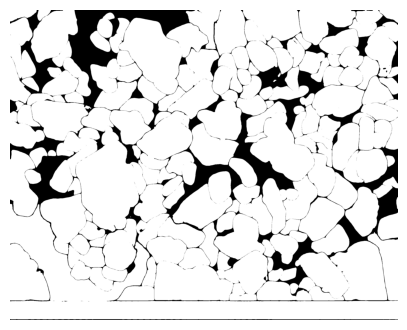

Saved combined black and white masked image as 'masked_images/combined_masked_image.png'


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an empty black mask
combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Grayscale mask

# Iterate through all masks and apply them
for mask in masks:
    segmentation = mask["segmentation"]  # Binary mask
    combined_mask[segmentation] = 255  # Set mask pixels to white (255)

# Save the final black and white mask
cv2.imwrite("masked_images/combined_masked_image.png", combined_mask)

# Display the saved mask
plt.figure(figsize=(5,5))
plt.imshow(combined_mask, cmap="gray")
plt.axis("off")
plt.show()

print("Saved combined black and white masked image as 'masked_images/combined_masked_image.png'")
